# ✅ 模型训练与评估改进版
改进点：删除泄露特征、添加噪声、编码分类变量、分层抽样、统一评估逻辑

=== 检查数据泄露 ===
Categorical feature user_id 转化率分布：
{'U0': 1.0, 'U317': 1.0, 'U349': 1.0, 'U348': 1.0, 'U347': 1.0, 'U346': 1.0, 'U345': 1.0, 'U344': 1.0, 'U343': 1.0, 'U342': 1.0, 'U340': 1.0, 'U337': 1.0, 'U336': 1.0, 'U332': 1.0, 'U331': 1.0, 'U327': 1.0, 'U1': 1.0, 'U32': 1.0, 'U319': 1.0, 'U35': 1.0, 'U356': 1.0, 'U36': 1.0, 'U380': 1.0, 'U394': 1.0, 'U393': 1.0, 'U39': 1.0, 'U387': 1.0, 'U385': 1.0, 'U382': 1.0, 'U381': 1.0, 'U379': 1.0, 'U363': 1.0, 'U375': 1.0, 'U373': 1.0, 'U372': 1.0, 'U371': 1.0, 'U370': 1.0, 'U368': 1.0, 'U365': 1.0, 'U318': 1.0, 'U316': 1.0, 'U245': 1.0, 'U315': 1.0, 'U275': 1.0, 'U272': 1.0, 'U270': 1.0, 'U267': 1.0, 'U264': 1.0, 'U263': 1.0, 'U261': 1.0, 'U260': 1.0, 'U26': 1.0, 'U258': 1.0, 'U257': 1.0, 'U256': 1.0, 'U252': 1.0, 'U251': 1.0, 'U250': 1.0, 'U25': 1.0, 'U248': 1.0, 'U277': 1.0, 'U279': 1.0, 'U281': 1.0, 'U300': 1.0, 'U314': 1.0, 'U313': 1.0, 'U312': 1.0, 'U311': 1.0, 'U309': 1.0, 'U304': 1.0, 'U303': 1.0, 'U30': 1.0, 'U283': 1.0, 'U299': 1.0

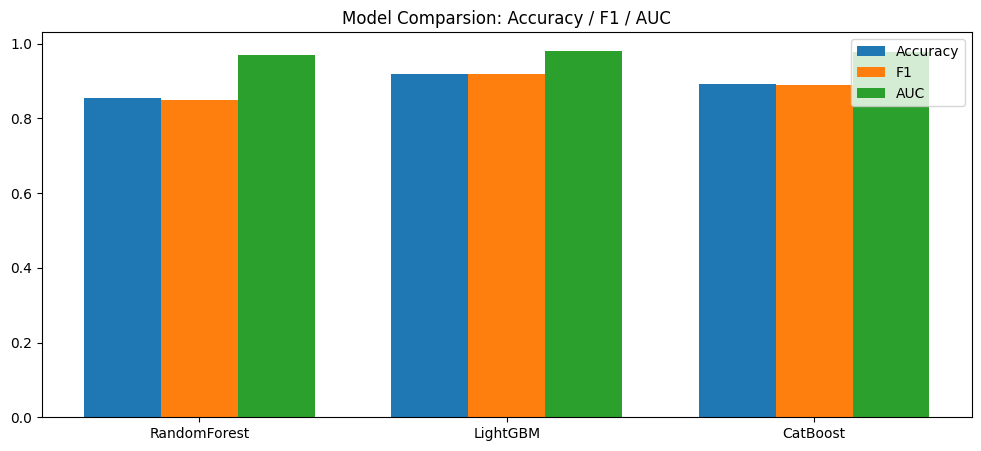

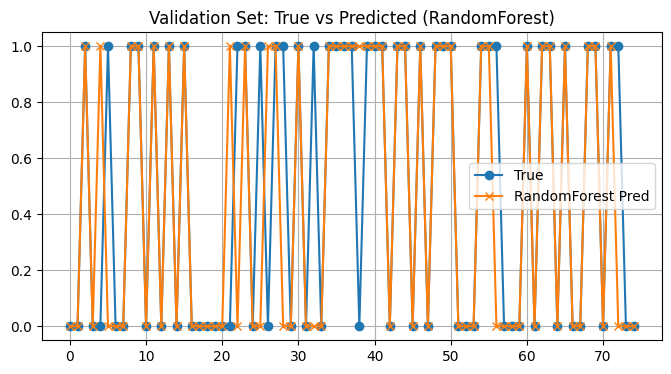

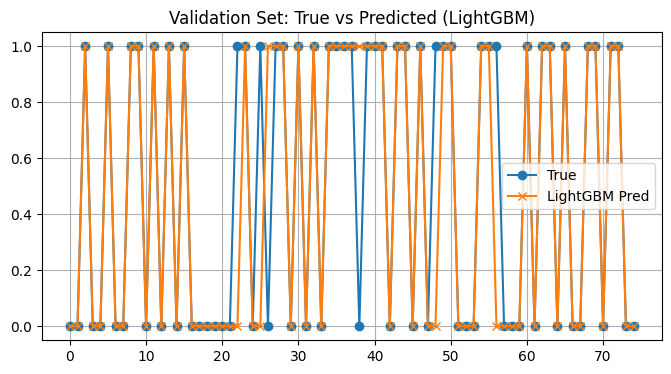

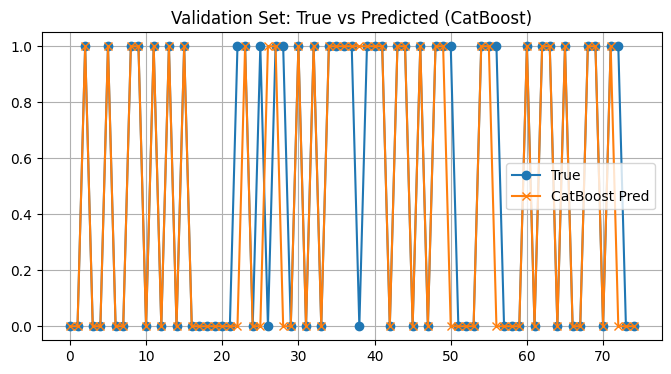

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn import set_config

set_config(transform_output="pandas")


def check_data_leakage(df: pd.DataFrame, target_col: str):
    """
    简单检查每个特征与 target_col 的相关性（如果是数值）或类别分布对比（如果是类别）；
    若某个特征几乎完美预测 target，则可能是泄露特征。
    """
    print("=== 检查数据泄露 ===")
    for col in df.columns:
        if col == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            corr = df[col].corr(df[target_col])
            print(f"Numeric feature {col} 与 {target_col} 相关系数: {corr:.4f}")
        else:
            # 对每个类别，计算该类别中 target 的转换率
            rates = df.groupby(col)[target_col].mean().sort_values(ascending=False)
            print(f"Categorical feature {col} 转化率分布：")
            print(rates.to_dict())
    print("======================\n")

# ========== 主流程 ==========


df = pd.read_csv("/Users/zipengzhu/Desktop/ecommerce_recommender_template/src/data/sample_converted_dataset.csv")

# 第 0 步：检查数据泄露
check_data_leakage(df, "converted")

# 第 1 步：定义特征与标签
X = df.drop(columns=["converted"])
y = df["converted"]

# 第 2 步：识别需要 one-hot 编码的类别特征
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# 第 3 步：构建 ColumnTransformer （对类别做 one-hot，对数值直接 passthrough）
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# 第 4 步：建立 pipeline（预处理 + 模型）— 但我们先拆分 train/val/test，再 fit 各模型

# 第 5 步：拆分数据为 train / temp （用于 val + test）再拆出 validation / test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("样本数量：", "train", len(X_train), "val", len(X_val), "test", len(X_test))

# 第 6 步：定义模型列表
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}

# 存放 fit 后的 pipeline（预处理 + 模型）
pipelines = {}
# 存放预测概率与标签
pred_proba = {}
pred_label = {}
metrics = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    pipelines[name] = pipe

    # Use predict_proba to get the probability of the positive class
    proba = pipelines[name].predict_proba(X_val)[:, 1]
    pred = (proba >= 0.5).astype(int)

    pred_proba[name] = proba
    pred_label[name] = pred

    acc = accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred)
    auc = roc_auc_score(y_val, proba)
    cm = confusion_matrix(y_val, pred)

    metrics[name] = {
        "accuracy": acc,
        "f1_score": f1,
        "auc": auc,
        "confusion_matrix": cm
    }

    print(f"--- {name} 评估结果 ---")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:\n", cm)
    print()

# 第 7 步：画对比图（Accuracy, F1, AUC）

names = list(models.keys())
acc_list = [metrics[n]["accuracy"] for n in names]
f1_list = [metrics[n]["f1_score"] for n in names]
auc_list = [metrics[n]["auc"] for n in names]

x = np.arange(len(names))
width = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - width, acc_list, width, label="Accuracy")
plt.bar(x, f1_list, width, label="F1")
plt.bar(x + width, auc_list, width, label="AUC")
plt.xticks(x, names)
plt.legend()
plt.title("Model Comparsion: Accuracy / F1 / AUC")
plt.show()

# 第 8 步：画 True vs Predicted 曲线（按模型分别画）

for name in names:
    plt.figure(figsize=(8, 4))
    true_arr = np.array(y_val).ravel()
    pred_arr = pred_label[name].ravel()
    plt.plot(true_arr, label="True", marker="o")
    plt.plot(pred_arr, label=f"{name} Pred", marker="x")
    plt.title(f"Validation Set: True vs Predicted ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()